In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
#from sklearn import decomposition
#from sklearn.cluster import DBSCAN
#from Behavior.behavior import get_extent, density_map, get_idxs_behav_state
#from spatial import gaussian_kernel_2D, get_field_patches
from target import get_spike_counts

#from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [5]:
session    = selected[1]
exp_states = {'SIL': 0, 'BGR': 1, 'TGT': 2}

animal = session.split('_')[0]
s_path           = os.path.join(source, animal, session)
meta_file        = os.path.join(source, animal, session, 'meta.h5')
units_file       = os.path.join(source, animal, session, 'units.h5')
moseq_file       = os.path.join(source, animal, session, 'MoSeq.h5')

with h5py.File(meta_file, 'r') as f:
    #tl = np.array(f['processed']['timeline'])
    #tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(moseq_file, 'r') as f:
    moseq = np.array(f['moseq'])
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        
width = 75  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
dt = np.diff(moseq[:, 0])
speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()

speed_thresh = 0.05  # m/s
idxs_rest_ev = np.where(speed_smooth[events[:, 2].astype(np.int32)] < speed_thresh)[0]
idxs_run_ev  = np.where(speed_smooth[events[:, 2].astype(np.int32)] > speed_thresh)[0]

# filter by experimental state
idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
idxs_sil_ev = np.where(events[:, 1] == 0)[0]

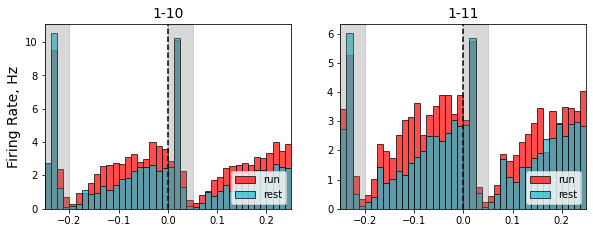

In [6]:
idxs_state_ev = idxs_bgr_ev
psth_times_A  = events[np.intersect1d(idxs_rest_ev, idxs_state_ev)][:, 0] 
psth_times_B  = events[np.intersect1d(idxs_run_ev, idxs_state_ev)][:, 0]
to_plot = [name for name in unit_names if int(name[0]) < 3]

hw, bc = 0.25, 41
cols = 3
rows = int(np.ceil(len(to_plot)/3))
fig = plt.figure(figsize=(15, rows*4))

for i, unit_name in enumerate(to_plot[:2]):
    bins, counts_A = get_spike_counts(spike_times[unit_name], psth_times_A, hw, bc)
    bins, counts_B = get_spike_counts(spike_times[unit_name], psth_times_B, hw, bc)
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=counts_B, edgecolor='black', color='red', alpha=0.7, label='run')
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='tab:cyan', alpha=0.7, label='rest')
    
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
    ax.set_title(unit_name, fontsize=14)
    ax.legend(loc='lower right', prop={'size': 10})
    ax.set_xlim(-hw, hw)
    if i % 3 == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)

## Quick tests: smoothing and data balance

136983

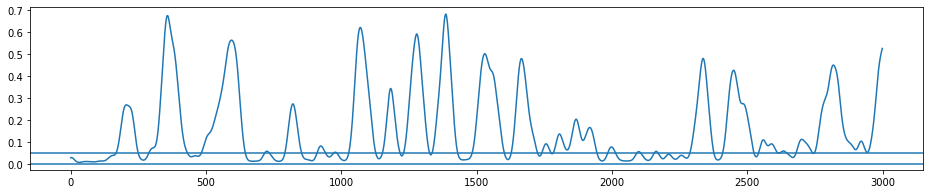

In [7]:
# quick testing - speed smoothing
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(speed_smooth[:3000])
ax.axhline(0)
ax.axhline(speed_thresh)
len(np.where(speed_smooth < speed_thresh)[0])

In [12]:
percents = []
for session in selected:
    animal = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'MoSeq.h5')

    with h5py.File(moseq_file, 'r') as f:
        moseq = np.array(f['moseq'])

    width = 75  # 100 points ~= 1 sec with at 100Hz
    kernel = signal.gaussian(width, std=(width) / 7.2)
    dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
    dt = np.diff(moseq[:, 0])
    speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
    speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()
    
    thresh = 0.05  # m/s
    p_run  = len(np.where(speed_smooth > thresh)[0])/len(speed_smooth)
    p_rest = len(np.where(speed_smooth < thresh)[0])/len(speed_smooth)
    print("%s: %.2f run, %.2f rest" % (session[-19:-6], p_run, p_rest))
    
    percents.append([p_run, p_rest])
    
percents = np.array(percents)

print("Avgs: %.2f run, %.2f rest" % (percents[:, 0].mean(), percents[:, 1].mean()))

2023-04-17_17: 0.54 run, 0.46 rest
2023-04-18_10: 0.43 run, 0.57 rest
2023-04-18_17: 0.48 run, 0.52 rest
2023-04-19_10: 0.42 run, 0.58 rest
2023-04-20_08: 0.36 run, 0.64 rest
2023-04-20_15: 0.42 run, 0.58 rest
2023-04-21_08: 0.43 run, 0.57 rest
2023-04-21_13: 0.46 run, 0.54 rest
2023-04-24_10: 0.45 run, 0.55 rest
2023-04-24_16: 0.43 run, 0.57 rest
2023-04-26_08: 0.39 run, 0.61 rest
2023-05-02_12: 0.44 run, 0.56 rest
2023-05-04_19: 0.57 run, 0.43 rest
2023-05-22_09: 0.38 run, 0.62 rest
2023-05-23_09: 0.44 run, 0.56 rest
2023-05-25_15: 0.39 run, 0.61 rest
2023-06-14_08: 0.49 run, 0.51 rest
2023-06-19_08: 0.49 run, 0.51 rest
Avgs: 0.44 run, 0.56 rest


## Speed modulation

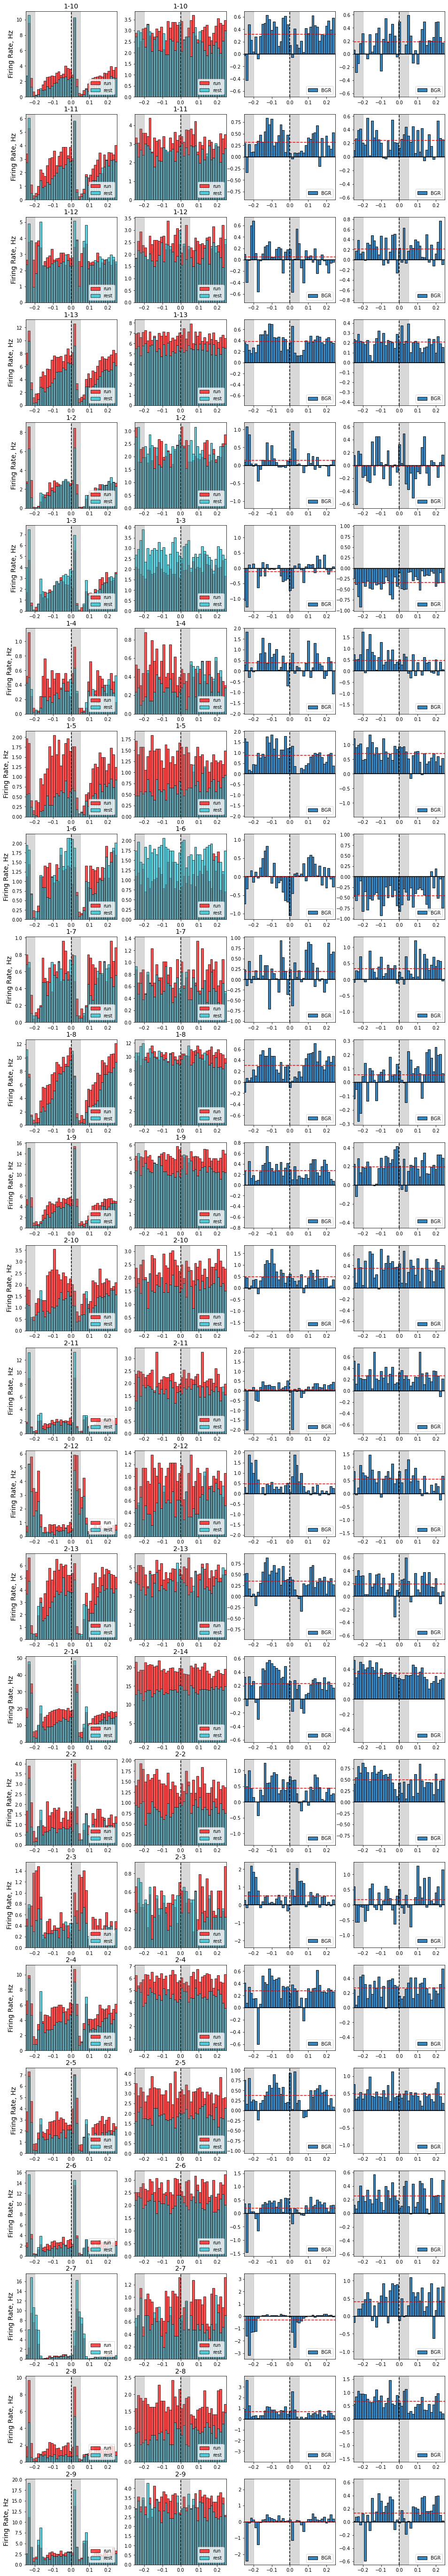

In [8]:
to_plot = [name for name in unit_names if int(name[0]) < 3]

hw, bc = 0.25, 41
cols = 4
rows = len(to_plot)
fig, axes = plt.subplots(rows, cols, figsize=(16, rows*4))

for i, unit_name in enumerate(to_plot[:]):
    deltas = []
    for j, idxs_state in enumerate([idxs_bgr_ev, idxs_sil_ev]):
        idxs_rest_st_ev = np.intersect1d(idxs_rest_ev, idxs_state)
        idxs_run_st_ev  = np.intersect1d(idxs_run_ev, idxs_state)
        bins, counts_A = get_spike_counts(spike_times[unit_name], events[idxs_rest_st_ev][:, 0], hw, bc)
        bins, counts_B = get_spike_counts(spike_times[unit_name], events[idxs_run_st_ev][:, 0], hw, bc)
        deltas.append( (counts_B - counts_A)/ (0.5*(counts_B + counts_A)).mean() )

        ax = axes[i][j]
        ax.hist(bins[:-1], bins=bins, weights=counts_B, edgecolor='black', color='red', alpha=0.7, label='run')
        ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='tab:cyan', alpha=0.7, label='rest')
        ax.axvline(0, color='black', ls='--')
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
        ax.set_title(unit_name, fontsize=14)
        ax.legend(loc='lower right', prop={'size': 10})
        ax.set_xlim(-hw, hw)
        if j == 0:
            ax.set_ylabel("Firing Rate, Hz", fontsize=14)
            
    colors = ['tab:blue', 'grey']
    for j, delta in enumerate(deltas):
        d_max = np.abs(delta).max()
        ax = axes[i][j + 2]
        ax.axvline(0, color='black', ls='--')
        ax.axhline(0, color='black', ls='-')
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
        ax.bar(bins[:-1], delta, width=0.1/8, edgecolor='black', alpha=0.9, color='tab:blue', label='BGR')
        ax.legend(loc='lower right', prop={'size': 10})
        ax.set_ylim(-d_max*1.1, d_max*1.1)
        ax.set_xlim(-hw, hw)
        ax.axhline(delta.mean(), color='red', ls='--')